In [228]:
#@title Setup & Imports
import os
import zipfile
import pandas as pd
from src.MAE.MAE_dataset import MAEDataset
from src.MAE.MAE_model import MaskedAutoencoderCNN
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



from PIL import Image
import json
# import nltk
# from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
# from nltk.translate.meteor_score import meteor_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
import io
import random
from src.config import *
from src.dataset import load_csv_paths, create_dataloaders
from src.utils import build_vocab
from src.model import GRNN
from src.train import train_model, plot_history
from src.eval import test_loss, generate_question
from src.dataset import VQGTensorDataset
from src.model import TransformerModel
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [154]:
import nltk
import os

nltk.download('punkt', download_dir='~/nltk_data')
nltk.data.path.append(os.path.expanduser('~/nltk_data'))


[nltk_data] Downloading package punkt to ~/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [155]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jacobfernandez/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [136]:
import pandas as pd

def expand_questions(csv_path):
    df = pd.read_csv(csv_path)
    expanded_rows = []
    for _, row in df.iterrows():
        questions = str(row["questions"]).split('---')
        for q in questions:
            q = q.strip()
            if q:
                expanded_rows.append({
                    "image_id": row["image_id"],
                    "tensor_path": row["tensor_path"],
                    "questions": q  # single question per row
                })
    return pd.DataFrame(expanded_rows)


In [277]:
import os
import pandas as pd

# === CSV file paths ===
bing_csvs = [
    "data/bing_data/bing_redistributed_indexes/bing_train_tensor_index.csv",
    "data/bing_data/bing_redistributed_indexes/bing_val_tensor_index.csv",
    "data/bing_data/bing_redistributed_indexes/bing_test_tensor_index.csv"
]

flickr_csvs = [
    "data/flickr_data/flickr_redistributed_indexes/flickr_train_tensor_index.csv",
    "data/flickr_data/flickr_redistributed_indexes/flickr_val_tensor_index.csv",
    "data/flickr_data/flickr_redistributed_indexes/flickr_test_tensor_index.csv"
]

# === Load, tag, and store all dataframes ===
dfs = []

for path in bing_csvs:
    df = pd.read_csv(path)
    df["source"] = "bing"
    dfs.append(df)

for path in flickr_csvs:
    df = pd.read_csv(path)
    df["source"] = "flickr"
    dfs.append(df)

# === Combine and clean ===
combined_df = pd.concat(dfs, ignore_index=True)
combined_df = combined_df.dropna(subset=["tensor_path"]).reset_index(drop=True)
combined_df["tensor_path"] = combined_df["tensor_path"].apply(os.path.basename)

print(f"✅ Final combined dataset size: {len(combined_df)}")

# === Save to flat data/ directory ===
combined_path = "data/combined_tensor_index.csv"
combined_df.to_csv(combined_path, index=False)
print(f"📁 Saved to {combined_path}")


✅ Final combined dataset size: 3611
📁 Saved to data/combined_tensor_index.csv


In [ ]:
# combined_csv_path = "data/combined_tensor_index.csv"
# combined_df.to_csv(combined_csv_path, index=False)

In [ ]:
# Direct paths to CSVs
# train_csv = "data/flickr_data/flickr_redistributed_indexes/flickr_train_tensor_index.csv"
# val_csv   = "data/flickr_data/flickr_redistributed_indexes/flickr_val_tensor_index.csv"
# test_csv  = "data/flickr_data/flickr_redistributed_indexes/flickr_test_tensor_index.csv"



# train_df = expand_questions(train_csv)
# val_df = expand_questions(val_csv)
# test_df = expand_questions(test_csv)


# Read all questions from all splits
# questions = []
# for path in [train_csv, val_csv, test_csv]:
#     df = pd.read_csv(path)
#     questions.extend(df["questions"].dropna().tolist())


In [278]:
combined_csv = "data/combined_tensor_index.csv"
full_df = expand_questions(combined_csv)

In [ ]:
# train_df = expand_questions(train_csv)
# val_df = expand_questions(val_csv)
# test_df = expand_questions(test_csv)

In [ ]:
# train_exp_csv = "data/flickr_data/flickr_train_expanded.csv"
# val_exp_csv   = "data/flickr_data/flickr_val_expanded.csv"
# test_exp_csv  = "data/flickr_data/flickr_test_expanded.csv"

# train_df.to_csv(train_exp_csv, index=False)
# val_df.to_csv(val_exp_csv, index=False)
# test_df.to_csv(test_exp_csv, index=False)

In [ ]:
train_df, temp_df = train_test_split(
    full_df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Step 2: Split temp into val and test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,  # half of 20% = 10%
    random_state=42,
    shuffle=True
)

# Confirm sizes
print(f"Train: {len(train_df)}")
print(f"Val: {len(val_df)}")
print(f"Test: {len(test_df)}")

# Optional: save to CSVs
train_df.to_csv("data/combined_train_tensor_index.csv", index=False)
val_df.to_csv("data/combined_val_tensor_index.csv", index=False)
test_df.to_csv("data/combined_test_tensor_index.csv", index=False)

Train: 14456
Val: 1807
Test: 1808


In [299]:
train_comb_csv = "data/combined_train_tensor_index.csv"
val_comb_csv   = "data/combined_val_tensor_index.csv"
test_comb_csv  = "data/combined_test_tensor_index.csv"

In [307]:

questions = pd.concat([train_df, val_df, test_df])["questions"].dropna().tolist()
vocab, idx_to_word = build_vocab(questions)

# Datasets with base_dir for .pt files
# BASE_DIR = "data"
train_dataset = VQGTensorDataset(train_comb_csv, vocab, MAX_LENGTH)
val_dataset   = VQGTensorDataset(val_comb_csv, vocab, MAX_LENGTH)
test_dataset  = VQGTensorDataset(test_comb_csv, vocab, MAX_LENGTH)

# Dataloaders
from torch.utils.data import DataLoader
dataloaders = {
    "flickr": {
        "train": DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
        "val":   DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False),
        "test":  DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False),
    }
}


In [318]:
model = GRNN(EMBED_SIZE, HIDDEN_SIZE, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)



Epoch 25: 100%|██████████| 226/226 [01:01<00:00,  3.70it/s]


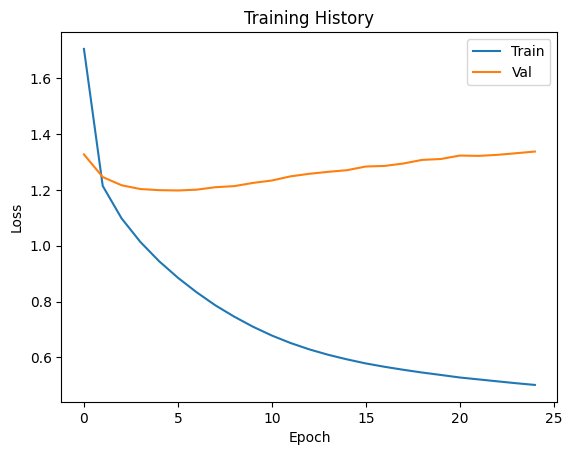

📉 Test Loss: 1.3147


In [319]:
history = train_model(model, dataloaders["flickr"]["train"], dataloaders["flickr"]["val"],
                      vocab, criterion, optimizer, device, 25)
plot_history(history)
test_loss(model, dataloaders["flickr"]["test"], vocab, criterion, device)


In [348]:
import torch.nn as nn
import torch
import torchvision.models as models
import math

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape (1, max_len, embed_dim)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, embed_dim)
        x = x + self.pe[:, :x.size(1)]
        return x

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Embedding(vocab_size, embed_size),
            nn.BatchNorm1d(embed_size)
        )
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, vocab_size),
            nn.BatchNorm1d(vocab_size)
        )

    def forward(self, features, captions):
        emb = self.embed[0](captions)
        B, T, E = emb.shape
        emb = self.embed[1](emb.view(-1, E)).view(B, T, E)

        inputs = torch.cat((features.unsqueeze(1), emb[:, :-1, :]), dim=1)
        out, _ = self.gru(inputs)
        logits = self.linear[0](out)
        logits = self.linear[1](logits.view(-1, logits.size(-1))).view(*logits.shape)
        return logits

class DecoderLSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Embedding(vocab_size, embed_size),
            nn.BatchNorm1d(embed_size)
        )
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, vocab_size),
            nn.BatchNorm1d(vocab_size)
        )

    def forward(self, features, captions):
        emb = self.embed[0](captions)
        B, T, E = emb.shape
        emb = self.embed[1](emb.view(-1, E)).view(B, T, E)

        inputs = torch.cat((features.unsqueeze(1), emb[:, :-1, :]), dim=1)
        out, _ = self.lstm(inputs)
        logits = self.linear[0](out)
        logits = self.linear[1](logits.view(-1, logits.size(-1))).view(*logits.shape)
        return logits

class DecoderTransformer(nn.Module):
    def __init__(self, embed_size, vocab_size, num_heads=4, num_layers=2, max_len=100):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Embedding(vocab_size, embed_size),
            nn.BatchNorm1d(embed_size)
        )
        self.pos_encoder = PositionalEncoding(embed_size, max_len)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.linear = nn.Sequential(
            nn.Linear(embed_size, vocab_size),
            nn.BatchNorm1d(vocab_size)
        )

    def forward(self, features, captions):
        emb = self.embed[0](captions)
        B, T, E = emb.shape
        emb = self.embed[1](emb.view(-1, E)).view(B, T, E)

        inputs = torch.cat((features.unsqueeze(1), emb[:, :-1, :]), dim=1)
        pos_encoded = self.pos_encoder(inputs)

        out = self.transformer(pos_encoded)
        logits = self.linear[0](out)
        logits = self.linear[1](logits.view(-1, logits.size(-1))).view(*logits.shape)
        return logits


class GRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.project = nn.Sequential(
            nn.Linear(2048, embed_size),
            nn.BatchNorm1d(embed_size),
            nn.ReLU()
        )
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

    def forward(self, images, captions):
        feats = self.encoder(images).view(images.size(0), -1)
        projected_feats = self.project(feats)
        return self.decoder(projected_feats, captions)

class LSTMModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        resnet = models.resnet50()
        resnet.load_state_dict(torch.load("resnet50-0676ba61.pth"))
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.project = nn.Sequential(
            nn.Linear(2048, embed_size),
            nn.BatchNorm1d(embed_size),
            nn.ReLU()
        )
        self.decoder = DecoderLSTM(embed_size, hidden_size, vocab_size)

    def forward(self, images, captions):
        feats = self.encoder(images).view(images.size(0), -1)
        projected_feats = self.project(feats)
        return self.decoder(projected_feats, captions)

class TransformerModel(nn.Module):
    def __init__(self, embed_size, vocab_size, num_heads=4, num_layers=3):
        super().__init__()
        resnet = models.resnet50()
        resnet.load_state_dict(torch.load("resnet50-0676ba61.pth"))
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.project = nn.Sequential(
            nn.Linear(2048, embed_size),
            nn.BatchNorm1d(embed_size),
            nn.ReLU()
        )
        self.decoder = DecoderTransformer(embed_size, vocab_size, num_heads, num_layers)

    def forward(self, images, captions):
        feats = self.encoder(images).view(images.size(0), -1)
        projected_feats = self.project(feats)
        return self.decoder(projected_feats, captions)


In [339]:
# from src.model import LSTMModel  # assuming you've imported from your updated model.py

lstm_model = LSTMModel(EMBED_SIZE, HIDDEN_SIZE, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=LR, weight_decay=1e-5)


In [342]:
history_lstm = train_model(lstm_model, dataloaders["flickr"]["train"], dataloaders["flickr"]["val"], vocab, criterion, optimizer, device, EPOCHS)
plot_history(*history_lstm, label="LSTM")
test_loss(lstm_model, dataloaders["flickr"]["test"], vocab, criterion, device)


Epoch 1:   4%|▍         | 10/226 [01:13<26:36,  7.39s/it]


KeyboardInterrupt: 

In [349]:
# from model import TransformerModel  # assuming you've imported from your updated model.py

transformer_model = TransformerModel(EMBED_SIZE, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=LR, weight_decay=1e-5)


In [ ]:
history_transformer = train_model(transformer_model, dataloaders["flickr"]["train"], dataloaders["flickr"]["val"], vocab, criterion, optimizer, device, EPOCHS)
plot_history(history_transformer, label="Transformer")
test_loss(lstm_model, dataloaders["flickr"]["test"], vocab, criterion, device)

Epoch 1:  46%|████▌     | 104/226 [13:34<15:55,  7.83s/it]


KeyboardInterrupt: 

In [ ]:
def generate_question(model, test_loader, vocab, idx_to_word, device):
    model.eval()
    images, _, texts = next(iter(test_loader))
    image = images[0].unsqueeze(0).to(device)
    original_question = texts[0]

    with torch.no_grad():
        feat = model.encoder(image)
        inp = torch.tensor([[vocab["<start>"]]], device=device)
        output = []
        for _ in range(20):
            out = model.decoder(feat, inp)
            pred = out[0, -1].argmax().item()
            if pred == vocab["<end>"]:
                break
            output.append(pred)
            inp = torch.cat([inp, torch.tensor([[pred]], device=device)], dim=1)

    decoded = " ".join(idx_to_word.get(i, "<unk>") for i in output)
    plt.imshow(image.cpu().squeeze().permute(1, 2, 0))
    plt.axis("off")
    plt.title(f"Generated: {decoded}\nOriginal: {original_question}")
    plt.show()

In [ ]:
generate_question(lstm_model, dataloaders["flickr"]["test"], vocab, idx_to_word, device=device)

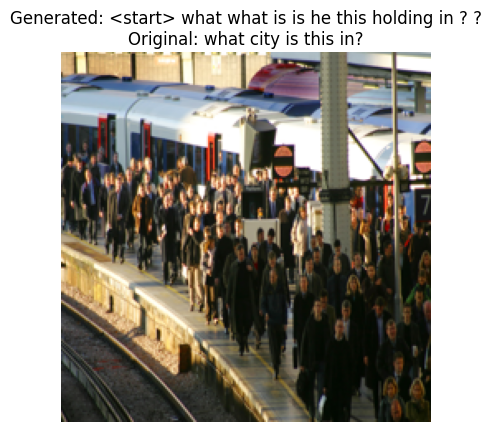

In [327]:
generate_question(model, dataloaders["flickr"]["test"], vocab, idx_to_word, device)

In [7]:
gqa_df = pd.read_csv('data/gqa_pretrain50k.csv')

In [12]:
train_df, temp_df = train_test_split(
    gqa_df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Step 2: Split temp into val and test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,  # half of 20% = 10%
    random_state=42,
    shuffle=True
)

# Confirm sizes
print(f"Train: {len(train_df)}")
print(f"Val: {len(val_df)}")
print(f"Test: {len(test_df)}")

# Optional: save to CSVs
train_df.to_csv("data/gqa_train_tensor_index.csv", index=False)
val_df.to_csv("data/gqa_val_tensor_index.csv", index=False)
test_df.to_csv("data/gqa_test_tensor_index.csv", index=False)

Train: 9314254
Val: 1164282
Test: 1164282


In [13]:
train_comb_csv = "data/gqa_train_tensor_index.csv"
val_comb_csv   = "data/gqa_val_tensor_index.csv"
test_comb_csv  = "data/gqa_test_tensor_index.csv"

In [27]:

questions = pd.concat([train_df, val_df, test_df])["questions"].dropna().tolist()
vocab, idx_to_word = build_vocab(questions)

# Datasets with base_dir for .pt files
# BASE_DIR = "data"
train_dataset = VQGTensorDataset(train_comb_csv, vocab, MAX_LENGTH)
val_dataset   = VQGTensorDataset(val_comb_csv, vocab, MAX_LENGTH)
test_dataset  = VQGTensorDataset(test_comb_csv, vocab, MAX_LENGTH)

# Dataloaders
from torch.utils.data import DataLoader
dataloaders = {
    "gqa": {
        "train": DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
        "val":   DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False),
        "test":  DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False),
    }
}


In [24]:
import torch.nn as nn
import torch
import torchvision.models as models

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Embedding(vocab_size, embed_size),
            nn.BatchNorm1d(embed_size)
        )
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, vocab_size),
            nn.BatchNorm1d(vocab_size)
        )

    def forward(self, features, captions):
        emb = self.embed[0](captions)
        B, T, E = emb.shape
        emb = self.embed[1](emb.view(-1, E)).view(B, T, E)

        inputs = torch.cat((features.unsqueeze(1), emb[:, :-1, :]), dim=1)
        out, _ = self.gru(inputs)
        logits = self.linear[0](out)
        logits = self.linear[1](logits.view(-1, logits.size(-1))).view(*logits.shape)
        return logits

class DecoderLSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Embedding(vocab_size, embed_size),
            nn.BatchNorm1d(embed_size)
        )
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, vocab_size),
            nn.BatchNorm1d(vocab_size)
        )

    def forward(self, features, captions):
        emb = self.embed[0](captions)
        B, T, E = emb.shape
        emb = self.embed[1](emb.view(-1, E)).view(B, T, E)

        inputs = torch.cat((features.unsqueeze(1), emb[:, :-1, :]), dim=1)
        out, _ = self.lstm(inputs)
        logits = self.linear[0](out)
        logits = self.linear[1](logits.view(-1, logits.size(-1))).view(*logits.shape)
        return logits

class DecoderTransformer(nn.Module):
    def __init__(self, embed_size, vocab_size, num_heads=4, num_layers=2):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Embedding(vocab_size, embed_size),
            nn.BatchNorm1d(embed_size)
        )
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.linear = nn.Sequential(
            nn.Linear(embed_size, vocab_size),
            nn.BatchNorm1d(vocab_size)
        )

    def forward(self, features, captions):
        emb = self.embed[0](captions)
        B, T, E = emb.shape
        emb = self.embed[1](emb.view(-1, E)).view(B, T, E)

        inputs = torch.cat((features.unsqueeze(1), emb[:, :-1, :]), dim=1)
        out = self.transformer(inputs)
        logits = self.linear[0](out)
        logits = self.linear[1](logits.view(-1, logits.size(-1))).view(*logits.shape)
        return logits

class GRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.project = nn.Sequential(
            nn.Linear(2048, embed_size),
            nn.BatchNorm1d(embed_size),
            nn.ReLU()
        )
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

    def forward(self, images, captions):
        feats = self.encoder(images).view(images.size(0), -1)
        projected_feats = self.project(feats)
        return self.decoder(projected_feats, captions)

class LSTMModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        # resnet.load_state_dict(torch.load("pretrained_encoder.pth"))
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.project = nn.Sequential(
            nn.Linear(2048, embed_size),
            nn.BatchNorm1d(embed_size),
            nn.ReLU()
        )
        self.decoder = DecoderLSTM(embed_size, hidden_size, vocab_size)

    def forward(self, images, captions):
        feats = self.encoder(images).view(images.size(0), -1)
        projected_feats = self.project(feats)
        return self.decoder(projected_feats, captions)

class TransformerModel(nn.Module):
    def __init__(self, embed_size, vocab_size, num_heads=4, num_layers=2, use_resnet=True):
        super().__init__()
        self.use_resnet = use_resnet

        if self.use_resnet:
            resnet = models.resnet50(pretrained=True)
            self.encoder = nn.Sequential(*list(resnet.children())[:-1])
            for param in self.encoder.parameters():
                param.requires_grad = False
            self.project = nn.Sequential(
                nn.Linear(2048, embed_size),
                nn.BatchNorm1d(embed_size),
                nn.ReLU()
            )
        else:
            # Directly project the 2048-dim precomputed tensor
            self.project = nn.Sequential(
                nn.Linear(2048, embed_size),
                nn.BatchNorm1d(embed_size),
                nn.ReLU()
            )

        self.decoder = DecoderTransformer(embed_size, vocab_size, num_heads, num_layers)

    def forward(self, images_or_feats, captions):
        if self.use_resnet:
            feats = self.encoder(images_or_feats).view(images_or_feats.size(0), -1)
        else:
            feats = images_or_feats  # already 2048-dim features
        projected_feats = self.project(feats)
        return self.decoder(projected_feats, captions)



In [28]:
# from model import TransformerModel  # assuming you've imported from your updated model.py

transformer_model = TransformerModel(EMBED_SIZE, len(vocab), use_resnet=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=LR, weight_decay=1e-5)


In [29]:
history_transformer = train_model(transformer_model, dataloaders["gqa"]["train"], dataloaders["gqa"]["val"], vocab, criterion, optimizer, device, EPOCHS)
plot_history(history_transformer, label="Transformer")
test_loss(lstm_model, dataloaders["gqa"]["test"], vocab, criterion, device)

Epoch 1:   0%|          | 59/582141 [00:02<8:09:21, 19.82it/s] 


KeyboardInterrupt: 

In [ ]:
#next steps: 1) Data Agument (labels) dataset -> retrain 2) SSL + Pretrain for Image and maybe decoder\


In [125]:
csvs = [
    "data/bing_data/bing_redistributed_indexes/bing_train_tensor_index.csv",
    "data/bing_data/bing_redistributed_indexes/bing_val_tensor_index.csv",
    "data/bing_data/bing_redistributed_indexes/bing_test_tensor_index.csv"
]


all_paths = []
for csv in csvs:
    df = pd.read_csv(csv)
    all_paths += [os.path.join("data/bing_data", p) for p in df["tensor_path"].dropna().tolist()]

print(f"✅ Loaded {len(all_paths)} image paths")


✅ Loaded 1922 image paths


In [ ]:
# mae_train.py
import torch
from torch.utils.data import DataLoader
from src.MAE.MAE_dataset import MAEDataset
from src.MAE.MAE_model import MaskedAutoencoderCNN
import os
import pandas as pd
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- CONFIG ---
EPOCHS = 15
BATCH_SIZE = 64
PATCH_SIZE = 16
MASK_RATIO = 0.5  # Reduced from 0.75
EMBED_DIM = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load paths using unified formatting
csvs = [
    "data/bing_data/bing_redistributed_indexes/bing_train_tensor_index.csv",
    "data/bing_data/bing_redistributed_indexes/bing_val_tensor_index.csv",
    "data/bing_data/bing_redistributed_indexes/bing_test_tensor_index.csv"
]

all_paths = []
for csv in csvs:
    df = pd.read_csv(csv)
    all_paths += [os.path.join("data/bing_data", p) for p in df["tensor_path"].dropna().tolist()]

print(f"✅ Loaded {len(all_paths)} image paths")

# Split train and val paths
train_paths = all_paths[:int(0.8 * len(all_paths))]
val_paths = all_paths[int(0.8 * len(all_paths)) :]

# Create datasets and dataloaders
train_dataset = MAEDataset(train_paths, patch_size=PATCH_SIZE, mask_ratio=MASK_RATIO)
val_dataset = MAEDataset(val_paths, patch_size=PATCH_SIZE, mask_ratio=MASK_RATIO)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model
model = MaskedAutoencoderCNN(embed_dim=EMBED_DIM, patch_size=PATCH_SIZE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
train_history = []
val_history = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for masked, target, mask in tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{EPOCHS}"):
        masked, target, mask = masked.to(DEVICE), target.to(DEVICE), mask.to(DEVICE)
        output = model(masked, mask)
        loss = F.mse_loss(output[mask], target[mask])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    train_history.append(avg_train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for masked, target, mask in tqdm(val_loader, desc=f"Val Epoch {epoch+1}/{EPOCHS}"):
            masked, target, mask = masked.to(DEVICE), target.to(DEVICE), mask.to(DEVICE)
            output = model(masked, mask)
            loss = F.mse_loss(output[mask], target[mask])
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_history.append(avg_val_loss)

    print(f"📉 Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

# Save encoder weights
torch.save(model.encoder.state_dict(), "pretrained_encoder.pth")
print("✅ Saved encoder weights to pretrained_encoder.pth")

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(train_history, label="Train Loss", marker='o')
plt.plot(val_history, label="Val Loss", marker='s')
plt.title("MAE Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss (masked patches)")
plt.grid(True)
plt.legend()
plt.show()


In [134]:
import random

def show_mae_reconstruction(model, dataset, idx=None):
    model.eval()
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)

    masked, target, mask = dataset[idx]
    masked = masked.unsqueeze(0).to(DEVICE)
    mask = mask.unsqueeze(0).to(DEVICE)
    target = target.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        out = model(masked, mask)

    recon_img = out[0]
    true_img = target[0]
    masked_img = masked[0]

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    def reconstruct_image(patches):
        grid = torch.zeros(3, 224, 224)
        n = 0
        for i in range(0, 224, PATCH_SIZE):
            for j in range(0, 224, PATCH_SIZE):
                grid[:, i:i+PATCH_SIZE, j:j+PATCH_SIZE] = patches[n]
                n += 1
        return grid.clamp(0, 1)

    axs[0].imshow(reconstruct_image(true_img).permute(1, 2, 0).cpu())
    axs[0].set_title("Original Image")

    axs[1].imshow(reconstruct_image(masked_img).permute(1, 2, 0).cpu())
    axs[1].set_title("Masked Input")

    axs[2].imshow(reconstruct_image(recon_img).permute(1, 2, 0).cpu())
    axs[2].set_title("Reconstruction")

    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


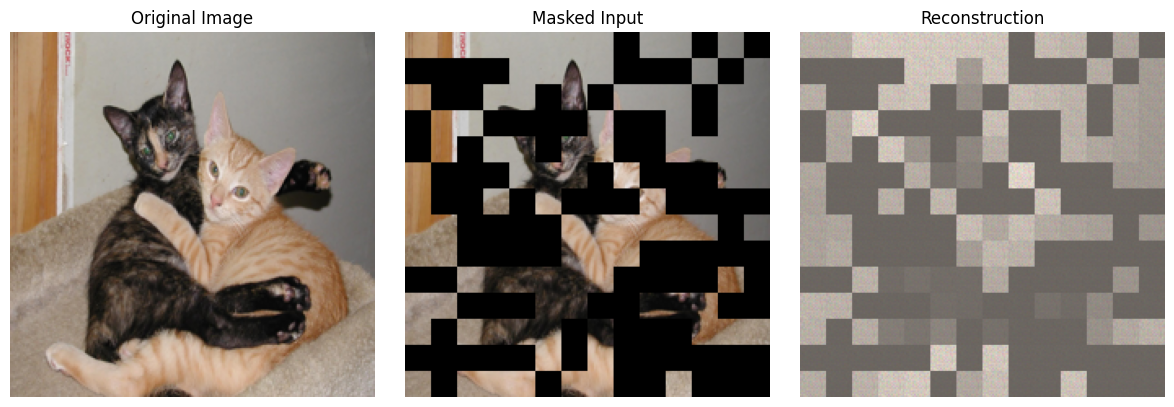

In [135]:
# Example usage
show_mae_reconstruction(model, val_dataset)

In [9]:
import pandas as pd
import torch
from torchvision import models, transforms
from PIL import Image
from pathlib import Path
from tqdm import tqdm

# ===== CONFIG =====
project_root = Path("data/coco")
COCO_DIR = project_root / "train_val2014"
TENSOR_DIR = project_root / "tensor_data"
CSV_OUTPUT = project_root / "coco_vqg_data.csv"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== MODEL SETUP =====
weights_path = "resnet50-0676ba61.pth"
resnet = models.resnet50()
resnet.load_state_dict(torch.load(weights_path, map_location=DEVICE))
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.eval().to(DEVICE)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ===== LOAD ALL CSVs =====
csv_paths = [
    project_root / "coco_train_all.csv",
    project_root / "coco_val_all.csv",
    project_root / "coco_test_all.csv"
]
combined_df = pd.concat([pd.read_csv(p) for p in csv_paths], ignore_index=True)

# ===== PROCESSING LOOP =====
rows = []
TENSOR_DIR.mkdir(parents=True, exist_ok=True)

for i, row in tqdm(combined_df.iterrows(), total=len(combined_df), desc="Processing COCO VQG"):
    image_id = int(row["image_id"])
    image_filename = f"COCO_train2014_{image_id:012d}.jpg"
    image_path = COCO_DIR / image_filename

    if not image_path.exists():
        continue

    try:
        img = Image.open(image_path).convert("RGB")
        tensor = transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            feat = resnet(tensor).squeeze().cpu()
        tensor_fname = f"coco_{image_id}.pt"
        tensor_path = TENSOR_DIR / tensor_fname
        if not tensor_path.exists():
            torch.save(feat, tensor_path)

        # Each question is separated by ---
        questions = str(row["questions"]).split("---")
        for q in questions:
            q = q.strip()
            if q:
                rows.append({
                    "tensor_path": tensor_fname,
                    "questions": q
                })

    except Exception as e:
        print(f"⚠️ Error processing image {image_filename}: {e}")
        continue

# ===== SAVE OUTPUT =====
vqg_df = pd.DataFrame(rows)
vqg_df.to_csv(CSV_OUTPUT, index=False)
print(f"✅ Saved {len(vqg_df)} image-question pairs to {CSV_OUTPUT}")


Processing COCO VQG: 100%|██████████| 4998/4998 [02:08<00:00, 39.04it/s]

✅ Saved 24971 image-question pairs to data/coco/coco_vqg_data.csv


In [12]:
coco_df = pd.read_csv("data/coco/coco_vqg_data.csv")
bing_df1 = pd.read_csv("data/bing_data/bing_train_expanded.csv")
bing_df2 = pd.read_csv("data/bing_data/bing_test_expanded.csv")
bing_df3 = pd.read_csv("data/bing_data/bing_val_expanded.csv")
flickr_df = pd.read_csv("data/flickr_data/flickr_test_expanded.csv")
flickr_df2 = pd.read_csv("data/flickr_data/flickr_train_expanded.csv")
flickr_df3 = pd.read_csv("data/flickr_data/flickr_val_expanded.csv")

In [13]:
full_df = pd.concat([coco_df, bing_df1, bing_df2, bing_df3, flickr_df,flickr_df2,flickr_df3])

In [18]:
train_df, temp_df = train_test_split(
    full_df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Step 2: Split temp into val and test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,  # half of 20% = 10%
    random_state=42,
    shuffle=True
)

# Confirm sizes
print(f"Train: {len(train_df)}")
print(f"Val: {len(val_df)}")
print(f"Test: {len(test_df)}")

# Optional: save to CSVs
train_df.to_csv("data/bfc_train_tensor_index.csv", index=False)
val_df.to_csv("data/bfc_val_tensor_index.csv", index=False)
test_df.to_csv("data/bfc_test_tensor_index.csv", index=False)

Train: 33688
Val: 4211
Test: 4212


In [19]:
train_comb_csv = "data/bfc_train_tensor_index.csv"
val_comb_csv = "data/bfc_val_tensor_index.csv"
test_comb_csv = "data/bfc_test_tensor_index.csv"

In [159]:
from src.dataset import VQGTensorDataset

In [150]:

questions = pd.concat([train_df, val_df, test_df])["questions"].dropna().tolist()
vocab, idx_to_word = build_vocab(questions)

# Datasets with base_dir for .pt files
# BASE_DIR = "data"
train_dataset = VQGTensorDataset(train_comb_csv, vocab, MAX_LENGTH)
val_dataset   = VQGTensorDataset(val_comb_csv, vocab, MAX_LENGTH)
test_dataset  = VQGTensorDataset(test_comb_csv, vocab, MAX_LENGTH)

# Dataloaders
from torch.utils.data import DataLoader
dataloaders = {
    "bfc_comb": {
        "train": DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
        "val":   DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False),
        "test":  DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False),
    }
}


In [116]:
transformer_model = TransformerModel(EMBED_SIZE, len(vocab), use_resnet = False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=LR, weight_decay=1e-5)

In [ ]:
# from model import TransformerModel  # assuming you've imported from your updated model.py



history_transformer = train_model(transformer_model, dataloaders["bfc_comb"]["train"], dataloaders["bfc_comb"]["val"], vocab, criterion, optimizer, device, EPOCHS)
plot_history(history_transformer, label="Transformer")

Epoch 25: 100%|██████████| 2106/2106 [01:32<00:00, 22.86it/s]


TypeError: plot_history() got an unexpected keyword argument 'label'

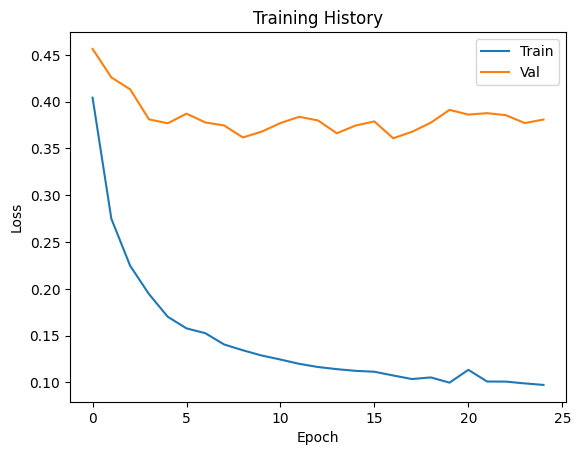

📉 Test Loss: 0.3691


In [83]:
plot_history(history_transformer)
test_loss(transformer_model, dataloaders["bfc_comb"]["test"], vocab, criterion, device)

In [108]:
test_loader = dataloaders["bfc_comb"]["test"]  

# Sample a batch and pick a random example from it
batch = next(iter(test_loader))
images, captions, raw_questions = batch
i = random.randint(0, len(images) - 1)
sample_tensor = images[i].unsqueeze(0).to(device)
true_question = raw_questions[i]

# === Load the trained model ===
model = TransformerModel(
    embed_size=EMBED_SIZE,
    vocab_size=len(vocab),
    use_resnet=False  # using precomputed 2048-dim features
)

model = torch.load("full_model.pth", map_location=device, weights_only=False)  # ← directly loads full model
model.to(device)
model.eval()

def generate_question(model, image_tensor, vocab, idx_to_word, max_len=MAX_LENGTH):
    with torch.no_grad():
        inp = torch.tensor([[vocab["<start>"]]], device=device)

        # Project the 2048-dim feature vector to match embed_size
        feat = model.project(image_tensor)  # [1, embed_size]
        
        output = []

        for _ in range(max_len):
            out = model.decoder(feat, inp)  # decoder expects projected feature
            pred = out[0, -1].argmax().item()
            if pred == vocab["<end>"]:
                break
            output.append(idx_to_word.get(pred, "<unk>"))
            inp = torch.cat([inp, torch.tensor([[pred]], device=device)], dim=1)
        
        return " ".join(output)


# === Run Inference ===
generated_question = generate_question(model, sample_tensor, vocab, idx_to_word)

# === Print Results ===
print("Ground-truth Question:", true_question)
print("Generated Question   :", generated_question)

Ground-truth Question: how do you make the perfect grilled cheese sandwich?
Generated Question   : <pad> ? <pad>


In [93]:
torch.save(transformer_model, "full_model.pth")

In [97]:
transformer_model = torch.load("full_model.pth", weights_only=False)


In [ ]:
# === Run inference ===
generated = generate_question(transformer_model, tensor, vocab, idx_to_word)
print("Generated Question:", generated)

In [163]:
expanded_bfc_train = expand_questions("data/bfc_train_tensor_index.csv")
expanded_bfc_test = expand_questions("data/bfc_test_tensor_index.csv")
expanded_bfc_val = expand_questions("data/bfc_val_tensor_index.csv")

In [173]:
import pandas as pd
from pathlib import Path

# Input file paths
csv_files = [
    "data/bfc_train_tensor_index.csv",
    "data/bfc_val_tensor_index.csv",
    "data/bfc_test_tensor_index.csv"
]

for file in csv_files:
    df = pd.read_csv(file)

    # Clean the tensor_path column
    df["tensor_path"] = df["tensor_path"].apply(
        lambda x: x.replace("tensor_data/", "") if x.startswith("tensor_data/flickr_") or x.startswith("tensor_data/bing_") else x
    )

    # Optionally overwrite the file or save new one
    df.to_csv(file, index=False)
    print(f"✅ Cleaned: {file}")


✅ Cleaned: data/bfc_train_tensor_index.csv
✅ Cleaned: data/bfc_val_tensor_index.csv
✅ Cleaned: data/bfc_test_tensor_index.csv


In [174]:
import torch
import pandas as pd
from torchvision import models
from pathlib import Path
from tqdm import tqdm

# Load pretrained ResNet50 (remove final layer)
resnet = models.resnet50()
weights_path = "resnet50-0676ba61.pth"  # adjust as needed
resnet.load_state_dict(torch.load(weights_path, map_location="cpu"))
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()

# Paths
resnet_dir = Path("data/resnet_data")
csv_paths = [
    "data/bfc_train_tensor_index.csv",
    "data/bfc_val_tensor_index.csv",
    "data/bfc_test_tensor_index.csv"
]

# Process all tensor paths listed in the CSVs
for csv_path in csv_paths:
    df = pd.read_csv(csv_path)

    for tensor_name in tqdm(df["tensor_path"], desc=f"Checking {csv_path}"):
        pt_path = resnet_dir / Path(tensor_name).name

        if not pt_path.exists():
            print(f"⚠️ Missing: {pt_path}")
            continue

        try:
            tensor = torch.load(pt_path)

            if tensor.ndim == 1 and tensor.shape[0] == 2048:
                continue  # Already valid

            if tensor.ndim == 3:
                tensor = tensor.unsqueeze(0)
            elif tensor.ndim != 4:
                print(f"❌ Invalid shape {tensor.shape} in {pt_path.name}")
                continue

            with torch.no_grad():
                encoded = resnet(tensor).squeeze().cpu()
            torch.save(encoded, pt_path)  # Overwrite with ResNet-encoded version

        except Exception as e:
            print(f"❌ Failed to process {pt_path.name}: {e}")


Checking data/bfc_test_tensor_index.csv: 100%|██████████| 4212/4212 [00:00<00:00, 11240.57it/s]


In [164]:
train_df = expanded_bfc_train
test_df = expanded_bfc_test
val_df = expanded_bfc_val

In [195]:
import torch
from torchvision import models
from pathlib import Path
from tqdm import tqdm

# === CONFIG ===
sources = {
    "flickr": Path("data/tensor_data"),     # adjust if needed
    "coco1": Path("data/coco/train_val2014"),
    "coco2": Path("data/coco/test_2014")
}
output_dir = Path("data/final_resnet_data")
output_dir.mkdir(parents=True, exist_ok=True)

# === LOAD RESNET ===
resnet = models.resnet50()
weights_path = "resnet50-0676ba61.pth"  # adjust if needed
resnet.load_state_dict(torch.load(weights_path, map_location="cpu"))
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # remove classifier
resnet.eval()

# === PROCESS ALL FILES ===
for src_name, src_dir in sources.items():
    pt_files = list(src_dir.glob("*.pt"))
    print(f"\nProcessing {len(pt_files)} {src_name} files from {src_dir}...")

    for pt_file in tqdm(pt_files, desc=f"[{src_name}]"):
        try:
            tensor = torch.load(pt_file)

            # Skip if already encoded
            if tensor.ndim == 1 and tensor.shape[0] == 2048:
                encoded = tensor
            else:
                if tensor.ndim == 3:
                    tensor = tensor.unsqueeze(0)  # [1, 3, 224, 224]
                elif tensor.ndim != 4:
                    print(f"❌ Invalid shape {tensor.shape} in {pt_file.name}")
                    continue

                with torch.no_grad():
                    encoded = resnet(tensor).squeeze().cpu()

            # Save encoded vector
            out_path = output_dir / pt_file.name
            torch.save(encoded, out_path)

        except Exception as e:
            print(f"❌ Error processing {pt_file.name}: {e}")



Processing 64459 flickr files from data/tensor_data...


[flickr]: 100%|██████████| 64459/64459 [02:13<00:00, 481.04it/s]



Processing 0 coco1 files from data/coco/train_val2014...


[coco1]: 0it [00:00, ?it/s]



Processing 0 coco2 files from data/coco/test_2014...


[coco2]: 0it [00:00, ?it/s]


In [200]:
# -*- coding: utf-8 -*-
"""dataset.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/15lyXSu06z14MKsLJS0LZmEVRnh7U5Hrz
"""

from pathlib import Path
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
import nltk

class VQGTensorDataset(Dataset):
    def __init__(self, csv_path, vocab, max_length=20, tensor_dir="data"):
        self.df = pd.read_csv(csv_path)
        self.vocab = vocab
        self.max_length = max_length
        self.tensor_dir = Path(tensor_dir)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["tensor_path"].strip()

        # Route based on filename prefix
        if filename.startswith("flickr") or filename.startswith("bing"):
            base_path = self.tensor_dir /  "final_resnet_data" / Path(filename).name
        elif filename.startswith("coco"):
            base_path = self.tensor_dir / "final_resnet_data" / Path(filename).name
        else:
            base_path = self.tensor_dir / Path(filename).name  # fallback

        tensor_path = base_path.resolve()

        if not tensor_path.exists():
            raise FileNotFoundError(f"Tensor not found at {tensor_path}")

        image_tensor = torch.load(tensor_path).float()

        # Tokenize question
        question = str(row["questions"]).split('---')[0].strip().lower()
        tokens = nltk.word_tokenize(question)
        indices = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]
        indices = [self.vocab['<start>']] + indices + [self.vocab['<end>']]
        indices = indices[:self.max_length] + [self.vocab['<pad>']] * (self.max_length - len(indices))

        return image_tensor, torch.tensor(indices), question





def load_csv_paths(base_dir):
    """
    Recursively load CSV paths for train/val/test splits under 'bing' and 'flickr'.
    """
    csvs = {"bing": {}, "flickr": {}}

    for root, _, files in os.walk(base_dir):
        for fname in files:
            if not fname.endswith(".csv"):
                continue
            fpath = os.path.join(root, fname)
            if fname.startswith("bing_"):
                if "train" in fname:
                    csvs["bing"]["train"] = fpath
                elif "val" in fname:
                    csvs["bing"]["val"] = fpath
                elif "test" in fname:
                    csvs["bing"]["test"] = fpath
            elif fname.startswith("flickr_"):
                if "train" in fname:
                    csvs["flickr"]["train"] = fpath
                elif "val" in fname:
                    csvs["flickr"]["val"] = fpath
                elif "test" in fname:
                    csvs["flickr"]["test"] = fpath

    return csvs



def create_dataloaders(dataset_paths, vocab, batch_size, max_length):
    loaders = {}
    for domain, splits in dataset_paths.items():
        loaders[domain] = {}
        for split, path in splits.items():
            dataset = VQGTensorDataset(path, vocab, max_length)
            loaders[domain][split] = DataLoader(dataset, batch_size=batch_size, shuffle=(split == "train"))
    return loaders

In [201]:

questions = pd.concat([train_df, val_df, test_df])["questions"].dropna().tolist()
vocab, idx_to_word = build_vocab(questions)

# Datasets with base_dir for .pt files
# BASE_DIR = "data"
train_dataset = VQGTensorDataset("data/bfc_train_tensor_index.csv", vocab, MAX_LENGTH)
val_dataset   = VQGTensorDataset("data/bfc_val_tensor_index.csv", vocab, MAX_LENGTH)
test_dataset  = VQGTensorDataset("data/bfc_test_tensor_index.csv", vocab, MAX_LENGTH)

# Dataloaders
from torch.utils.data import DataLoader
dataloaders = {
    "bfc_comb": {
        "train": DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
        "val":   DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False),
        "test":  DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False),
    }
}


In [202]:
model = TransformerModel(
    embed_size=2048,
    vocab_size=len(vocab),
    num_heads=4,           # optional, defaults to 4
    num_layers=10,          # increase from 2 to 6, or any number
    use_resnet=False       # or True if using raw images
)

Epoch 25: 100%|██████████| 2106/2106 [02:00<00:00, 17.51it/s]


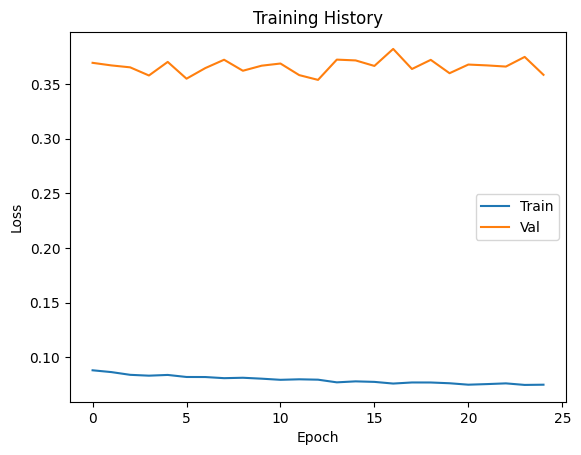

📉 Test Loss: 0.3425


In [203]:
# from model import TransformerModel  # assuming you've imported from your updated model.py



history_transformer = train_model(transformer_model, dataloaders["bfc_comb"]["train"], dataloaders["bfc_comb"]["val"], vocab, criterion, optimizer, device, EPOCHS)
plot_history(history_transformer)
test_loss(transformer_model, dataloaders["bfc_comb"]["test"], vocab, criterion, device)

📉 Test Loss: 0.3390


In [226]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

def generate_from_image(model, image_path, vocab, idx_to_word, device, resnet_weights_path, max_len=20):
    model.eval()
    model.to(device)

    # Load and preprocess the image
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Load custom ResNet50 from .pth file
    resnet = models.resnet50()
    resnet.load_state_dict(torch.load(resnet_weights_path, map_location=device))
    resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove final FC layer
    resnet.eval().to(device)

    # Get image feature embedding
    with torch.no_grad():
        image_tensor = resnet(image_tensor).squeeze().unsqueeze(0)

    # Optional projection if your VQG model uses img_fc
    if hasattr(model, "img_fc"):
        image_tensor = model.img_fc(image_tensor)

    # Generate the question
    inp = torch.tensor([[vocab["<start>"]]], device=device)
    output = []

    for _ in range(max_len):
        out = model(image_tensor, inp)
        pred = out[0, -1].argmax().item()
        if pred == vocab["<end>"]:
            break
        output.append(pred)
        inp = torch.cat([inp, torch.tensor([[pred]], device=device)], dim=1)

    generated_question = " ".join([idx_to_word[i] for i in output])

    # Display image and generated question
    plt.imshow(image)
    plt.axis("off")
    plt.title(generated_question)
    plt.show()

    print("Generated Question:", generated_question)
    return generated_question


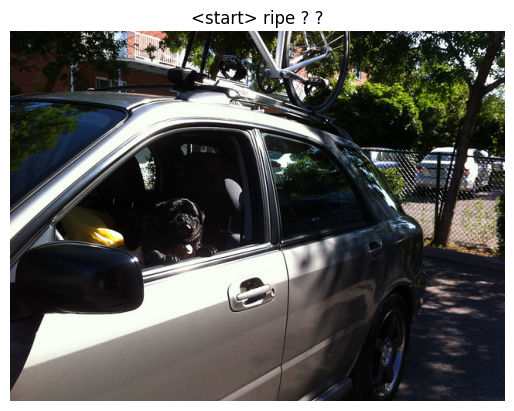

Generated Question: <start> ripe ? ?


'<start> ripe ? ?'

In [227]:
generate_from_image(
    model=transformer_model,
    image_path="data/coco/test2014/COCO_test2014_000000000027.jpg",
    vocab=vocab,
    idx_to_word=idx_to_word,
    device=DEVICE,
    resnet_weights_path="resnet50-0676ba61.pth"
)


In [238]:
import torch.nn as nn
import torch
import torchvision.models as models
import clip  # Add this import at the top of your file


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Embedding(vocab_size, embed_size),
            nn.BatchNorm1d(embed_size)
        )
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, vocab_size),
            nn.BatchNorm1d(vocab_size)
        )

    def forward(self, features, captions):
        emb = self.embed[0](captions)
        B, T, E = emb.shape
        emb = self.embed[1](emb.view(-1, E)).view(B, T, E)

        inputs = torch.cat((features.unsqueeze(1), emb[:, :-1, :]), dim=1)
        out, _ = self.gru(inputs)
        logits = self.linear[0](out)
        logits = self.linear[1](logits.view(-1, logits.size(-1))).view(*logits.shape)
        return logits

class DecoderLSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Embedding(vocab_size, embed_size),
            nn.BatchNorm1d(embed_size)
        )
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, vocab_size),
            nn.BatchNorm1d(vocab_size)
        )

    def forward(self, features, captions):
        emb = self.embed[0](captions)
        B, T, E = emb.shape
        emb = self.embed[1](emb.view(-1, E)).view(B, T, E)

        inputs = torch.cat((features.unsqueeze(1), emb[:, :-1, :]), dim=1)
        out, _ = self.lstm(inputs)
        logits = self.linear[0](out)
        logits = self.linear[1](logits.view(-1, logits.size(-1))).view(*logits.shape)
        return logits

class DecoderTransformer(nn.Module):
    def __init__(self, embed_size, vocab_size, num_heads=4, num_layers=2):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Embedding(vocab_size, embed_size),
            nn.BatchNorm1d(embed_size)
        )
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.linear = nn.Sequential(
            nn.Linear(embed_size, vocab_size),
            nn.BatchNorm1d(vocab_size)
        )

    def forward(self, features, captions):
        emb = self.embed[0](captions)
        B, T, E = emb.shape
        emb = self.embed[1](emb.view(-1, E)).view(B, T, E)

        inputs = torch.cat((features.unsqueeze(1), emb[:, :-1, :]), dim=1)
        out = self.transformer(inputs)
        logits = self.linear[0](out)
        logits = self.linear[1](logits.view(-1, logits.size(-1))).view(*logits.shape)
        return logits

class GRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.project = nn.Sequential(
            nn.Linear(2048, embed_size),
            nn.BatchNorm1d(embed_size),
            nn.ReLU()
        )
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

    def forward(self, images, captions):
        feats = self.encoder(images).view(images.size(0), -1)
        projected_feats = self.project(feats)
        return self.decoder(projected_feats, captions)

class LSTMModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        # resnet.load_state_dict(torch.load("pretrained_encoder.pth"))
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.project = nn.Sequential(
            nn.Linear(2048, embed_size),
            nn.BatchNorm1d(embed_size),
            nn.ReLU()
        )
        self.decoder = DecoderLSTM(embed_size, hidden_size, vocab_size)

    def forward(self, images, captions):
        feats = self.encoder(images).view(images.size(0), -1)
        projected_feats = self.project(feats)
        return self.decoder(projected_feats, captions)


class ClipTransformerModel(nn.Module):
    def __init__(self, embed_size, vocab_size, num_heads=4, num_layers=2, use_clip=True):
        super().__init__()
        self.use_clip = use_clip

        self.img_fc = nn.Linear(512, embed_size)  # CLIP ViT-B/16 has 512-dim output

        if self.use_clip:
            # Load CLIP's ViT-B/16 encoder
            self.clip_model, _ = clip.load("ViT-B/16", device="cpu")  # Move to GPU in forward
            for param in self.clip_model.visual.parameters():
                param.requires_grad = False
        else:
            # Fallback if using direct 2048-dim features
            self.project = nn.Sequential(
                nn.Linear(2048, embed_size),
                nn.BatchNorm1d(embed_size),
                nn.ReLU()
            )

        self.decoder = DecoderTransformer(embed_size, vocab_size, num_heads, num_layers)

    def forward(self, images_or_feats, captions):
        if self.use_clip:
            image_features = self.clip_model.encode_image(images_or_feats).float()  # CLIP expects normalized image tensors
        else:
            image_features = images_or_feats  # 2048-dim precomputed .pt

        projected_feats = self.img_fc(image_features)
        return self.decoder(projected_feats, captions)




# class TransformerModel(nn.Module):
#     def __init__(self, embed_size, vocab_size, num_heads=4, num_layers=2):
#         super().__init__()
#         resnet = models.resnet50(pretrained=True)
#         self.encoder = nn.Sequential(*list(resnet.children())[:-1])
#         for param in self.encoder.parameters():
#             param.requires_grad = False
#         self.project = nn.Sequential(
#             nn.Linear(2048, embed_size),
#             nn.BatchNorm1d(embed_size),
#             nn.ReLU()
#         )
#         self.decoder = DecoderTransformer(embed_size, vocab_size, num_heads, num_layers)

#     def forward(self, images, captions):
#         feats = self.encoder(images).view(images.size(0), -1)
#         projected_feats = self.project(feats)
#         return self.decoder(projected_feats, captions)

class TransformerModel(nn.Module):
    def __init__(self, embed_size, vocab_size, num_heads=4, num_layers=2, use_resnet=True):
        super().__init__()
        self.use_resnet = use_resnet

        self.img_fc = nn.Linear(2048, embed_size)
        


        if self.use_resnet:
            resnet = models.resnet50(pretrained=True)
            self.encoder = nn.Sequential(*list(resnet.children())[:-1])
            for param in self.encoder.parameters():
                param.requires_grad = False
            self.project = nn.Sequential(
                nn.Linear(2048, embed_size),
                nn.BatchNorm1d(embed_size),
                nn.ReLU()
            )
        else:
            # Directly project the 2048-dim precomputed tensor
            self.project = nn.Sequential(
                nn.Linear(2048, embed_size),
                nn.BatchNorm1d(embed_size),
                nn.ReLU()
            )

        self.decoder = DecoderTransformer(embed_size, vocab_size, num_heads, num_layers)

    def forward(self, images_or_feats, captions):
        if self.use_resnet:
            feats = self.encoder(images_or_feats).view(images_or_feats.size(0), -1)
        else:
            feats = images_or_feats  # already 2048-dim features
        projected_feats = self.project(feats)
        return self.decoder(projected_feats, captions)



In [ ]:
model = ClipTransformerModel(
    embed_size=1024,
    vocab_size=len(vocab),
    num_heads=4,           # optional, defaults to 4
    num_layers=6,          # increase from 2 to 6, or any number
    use_clip=True       # or True if using raw images
)

TypeError: ClipTransformerModel.__init__() got an unexpected keyword argument 'use_resnet'

In [ ]:
# from model import TransformerModel  # assuming you've imported from your updated model.py



history_transformer_clip = train_model(transformer_model, dataloaders["bfc_comb"]["train"], dataloaders["bfc_comb"]["val"], vocab, criterion, optimizer, device, EPOCHS)
plot_history(history_transformer_clip)
test_loss(transformer_model_clip, dataloaders["bfc_comb"]["test"], vocab, criterion, device)